In [2]:
from semantic_comms import calculate_psnr, train_semantic_communication_system, load_images, add_awgn_noise
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from semantic_extractor import SemanticBased
import os

folder_path = "output/original"
image_name = os.listdir(folder_path)[0]


semantic_images = SemanticBased(image_name=image_name, image_path=os.path.join(folder_path, image_name))
semantic_images.extract_images(color_image=True)

In [3]:
from semantic_models.sc1 import SemanticEncoder, SemanticDecoder

torch.manual_seed(42)
np.random.seed(42)

# Images
images = load_images("output/masks")
num_images = images.size(0)
image_channels = images.size(1)
image_height = images.size(2)
image_width = images.size(3)

# Reshape images tensor to fit the semantic encoder input shape
images = images.view(num_images, image_channels, image_height, image_width)

# Set the desired SNR and number of training epochs
snr = 12  # dB
num_epochs = 1500

# Train the semantic communication system
encoder_model = SemanticEncoder()
decoder_model = SemanticDecoder()

# encoder_model = SemanticEncoder2()
# decoder_model = SemanticDecoder2()

# encoder_model = SemanticEncoderTC()
# decoder_model = SemanticDecoderTC()

In [4]:
encoder, decoder = train_semantic_communication_system(encoder_model, decoder_model, images, snr, num_epochs)

Epoch: 10/1500, Loss: 0.42066293954849243
Epoch: 20/1500, Loss: 0.28794530034065247
Epoch: 30/1500, Loss: 0.19614121317863464
Epoch: 40/1500, Loss: 0.12818467617034912
Epoch: 50/1500, Loss: 0.0808829814195633
Epoch: 60/1500, Loss: 0.049110785126686096
Epoch: 70/1500, Loss: 0.028900453820824623
Epoch: 80/1500, Loss: 0.0166831873357296
Epoch: 90/1500, Loss: 0.009707157500088215
Epoch: 100/1500, Loss: 0.0059525626711547375
Epoch: 110/1500, Loss: 0.004033825825899839
Epoch: 120/1500, Loss: 0.0030869583133608103
Epoch: 130/1500, Loss: 0.002620942424982786
Epoch: 140/1500, Loss: 0.0023751086555421352
Epoch: 150/1500, Loss: 0.0022235149517655373
Epoch: 160/1500, Loss: 0.002112583490088582
Epoch: 170/1500, Loss: 0.00202073878608644
Epoch: 180/1500, Loss: 0.0019400563323870301
Epoch: 190/1500, Loss: 0.0018700790824368596
Epoch: 200/1500, Loss: 0.0018064662581309676
Epoch: 210/1500, Loss: 0.0017414172179996967
Epoch: 220/1500, Loss: 0.0016838227165862918
Epoch: 230/1500, Loss: 0.0016354363178834

In [5]:

# Calculate SNR
encoder_images = encoder(images)
noisy_images = add_awgn_noise(encoder_images, snr)
restored_images = decoder(noisy_images)
theta = 1.0

psnr = calculate_psnr(images, restored_images, theta)


print(images.shape)
print(encoder_images.shape)
print(restored_images.shape)
print(f"PSNR over AWGN channel: {psnr.item()} dB")

torch.Size([5, 3, 32, 32])
torch.Size([5, 32, 8, 8])
torch.Size([5, 3, 32, 32])
PSNR over AWGN channel: 26.11353302001953 dB


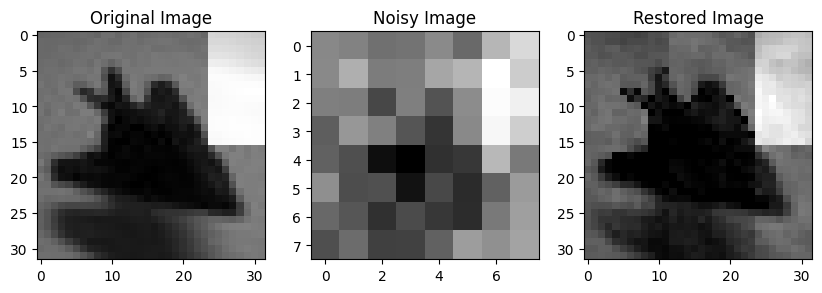

In [6]:
#plotting
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
im = images.detach().numpy()
im = np.sum(im, axis=0)
plt.imshow(im[0, :, :], cmap="gray")
plt.title("Original Image")
plt.subplot(1, 3, 2)
ns= noisy_images.detach().numpy()
ns = np.sum(ns, axis=0)
plt.imshow(ns[0, :, :], cmap="gray")
plt.title("Noisy Image")
plt.subplot(1, 3, 3)
rs= restored_images.detach().numpy()
#sum rs on axis 0 and 1
rs = np.sum(rs, axis=0)
plt.imshow(rs[0, :, :], cmap="gray")
plt.title("Restored Image")
plt.show()

In [7]:
import requests

def download_image(url, filename):
    response = requests.get(url)
    with open(filename, 'wb') as file:
        file.write(response.content)


In [13]:
from compressai.zoo import cheng2020_anchor

model = cheng2020_anchor(quality=6, pretrained=True).eval()

#download a sample image
import imageio
from skimage.transform import resize
from skimage import img_as_ubyte
from skimage.color import rgb2ycbcr, ycbcr2rgb
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import requests


#download a sample image
image = imageio.imread("https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/1200px-Cat03.jpg")
image = resize(image, (256, 256), anti_aliasing=True)

#convert to tensor
image = torch.from_numpy(image).permute(2, 0, 1).float().unsqueeze(0)

#compress and decompress
compressed_image = model.compress(image)
snr = 12
print(compressed_image)
noisy_images = add_awgn_noise(image, snr)

#decompress
reconstructed_image = model.decompress(compressed_image["strings"], compressed_image["shape"])

/tmp/ipykernel_45240/2826699829.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread("https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/1200px-Cat03.jpg")


{'strings': [[b'C\xb8Z\xe1&\xe8H\x17d\xc8\x16\x95l$\xd4\xa5\xe8\xccCIu)9yY\x1b\xa1d.\n\xb2\x9a\xc0\xce\xb3\xf8\xa7\x12\xcc\xa8c\x03K\x7f\x87)\xb2\xcai\xd6\xc7qe\xd5\xfd\xbc\xb1\xba\xd5\x02\xb8\x8e\xb4eD\x7f\x01\xfd\x1c\xab;\x8d\xa6\xed\x81\xf94\x90\x96\xe1\xe5(\x01g\xa0\xf8!\x08\xfc\xf6\x1c\xa4\xa5\x9e\xdaN\x11fN\xba\xac\xd2\x92\xf5=\xa6\x84`\xbe\x0b1\x191`\xe5>\xb1\x9a\xa0\x85T\xd3\xdc3kdy\xe0y\xd0#Q\xf1\xd34g\xcc\xb4\xdb\xe8N\x0b\x80TL\xa8\x04y=Y\xee\xc0\x89j\xc8EN\x00\x97q0\xc6,&m\x01\x88?\x7f\x11\xc3\x18\\*\t\x93e\xde\xcb=\x08d\xc9Q\x16\x93MaF\xe4\x13\xa44+\xdf\xb4v\xa8a\xf8\xf4\xa4\xe7!|\x0b\xef\xf8\xa4:t\x96\x19\xdf@2\xcf\xc2\xef\x0e\x17]!\x8b\xbc\x1a8N\x9e\xf7\x8dA \xe1\xf2\xd3\x11\xb2\x12S\xa8/\xb8DXiA2\xc7v,D\x16a\x98\xe8\x0f\x97f)\xaek\x05K_!\xce\x9cD\x8dm\x7f@\xe8.\xea\xe0\xa7\xef\x81]*~\xc3\xab\x9c\x0f*\x0c\xbc\xe7G\xe1\xbb\xab\xb3\xc7T\xfa\xe3\xdf\x1f\xae\xb5\'+=}\xe2\xcf%\xdev%\xe1B\xfc\xcaA4\xdbT\x9b\x88\xfb|\xc2\xb5\xb2\xc0\x85i\x0f\xa4\xf4\x834\x90Xi\xd5\xe3\xab\x10\x8

In [18]:
from compressai.zoo import cheng2020_anchor

model = cheng2020_anchor(quality=6, pretrained=True).eval()


def add_awgn_noise2(image, snr):
    # Extract the image data from the dictionary
    image_data = np.frombuffer(image['strings'][0], dtype=np.uint8)
    
    # Calculate the signal power and convert SNR from dB to linear scale
    signal_power = np.mean(image_data.astype(np.float64) ** 2)
    snr_linear = 10 ** (snr / 10)
    
    # Calculate the noise power
    noise_power = signal_power / snr_linear
    
    # Generate noise samples with the calculated power
    noise = np.random.normal(0, np.sqrt(noise_power), image_data.shape).astype(np.int16)
    
    # Add the noise to the image
    noisy_image_data = np.clip(image_data + noise, 0, 255).astype(np.uint8)
    
    # Create a new dictionary with the noisy image data
    noisy_image = {'strings': [noisy_image_data.tobytes()]}
    
    return noisy_image

# Compress and decompress
compressed_image = model.compress(image)
snr = 12
noisy_images = add_awgn_noise2(compressed_image, snr)

model.compress()

# Decompress
reconstructed_image = model.decompress(noisy_images, compressed_image["shape"])

TypeError: a bytes-like object is required, not 'list'

In [10]:
recon = reconstructed_image['x_hat'].squeeze(0).permute(1, 2, 0).detach().numpy()
im  = image.squeeze(0).permute(1, 2, 0).detach().numpy()

In [11]:
psnr = psnr(im, recon)

In [12]:
print(f"PSNR: {psnr} dB")

PSNR: 38.43202754955901 dB


In [22]:
import torch
import torch.nn as nn
from torchvision.transforms import functional as F
from vit_pytorch import ViT

class SemanticEncoderVIT(nn.Module):
    def __init__(self):
        super(SemanticEncoderVIT, self).__init__()
        self.encoder = ViT(
            image_size=32,
            patch_size=4,
            num_classes=512,
            dim=512,
            depth=6,
            heads=8,
            mlp_dim=1024,
            dropout=0.1,
            emb_dropout=0.1
        )

    def forward(self, x):
        encoded_features = self.encoder(x)  # Encode image features using ViT
        return encoded_features

class SemanticDecoderVIT(nn.Module):
    def __init__(self, num_tokens):
        super(SemanticDecoderVIT, self).__init__()
        self.num_tokens = num_tokens
        self.decoder = nn.Linear(512, num_tokens)

    def forward(self, x):
        logits = self.decoder(x)  # Generate logits for text generation
        return logits

# Example usage
encoder = SemanticEncoderVIT()
decoder = SemanticDecoderVIT(num_tokens=10000)  # Assuming you have a vocabulary of 10,000 tokens

# Assuming you have input image tensors 'images' of shape [batch_size, 3, 32, 32]
images = torch.randn(5, 3, 32, 32)
resized_images = F.resize(images, (32, 32))  # Resize images to match the expected size

encoded_features = encoder(resized_images)
logits = decoder(encoded_features)


/home/briancqi/anaconda3/envs/sam/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
